In [1]:
import numpy as np

import cv2

import matplotlib.pyplot as plt

from skimage.morphology import remove_small_objects, remove_small_holes

In [2]:
def remove_large_objects(img, max_size):
    return img & ~remove_small_objects(img, min_size=max_size)


class ProbioDetector:
    RGB_THRESHOLD_RANGES = ((0, 0, 0), (65, 65, 65))
    MORPH_KERNEL_SIZE = 5
    MIN_OBJECT_SIZE = 3000
    SMALL_HOLE_AREA_THRESHOLD = 7000
    TOO_LARGE_AREA_THRESHOLD = 50000

    @staticmethod
    def threshold(bgr_image: np.ndarray):
        # 1. multichannel histogram equalization
        copied_input = bgr_image.copy()
        calib_rgb = cv2.cvtColor(copied_input, cv2.COLOR_BGR2RGB)

        calib_eq_hist = calib_rgb

        # 2. thresholding
        thresholded = cv2.inRange(
            calib_eq_hist,
            ProbioDetector.RGB_THRESHOLD_RANGES[0],
            ProbioDetector.RGB_THRESHOLD_RANGES[1],
        )

        # 3. morphological opening to remove noise
        kernel = cv2.getStructuringElement(
            cv2.MORPH_CROSS,
            (ProbioDetector.MORPH_KERNEL_SIZE, ProbioDetector.MORPH_KERNEL_SIZE),
        )
        img = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel)

        # 4. morphological removing small objects - further denoising
        img_no_small_objects = remove_small_objects(
            img > 0, min_size=ProbioDetector.MIN_OBJECT_SIZE
        )

        img_no_large_objects = remove_large_objects(
            img_no_small_objects, max_size=ProbioDetector.TOO_LARGE_AREA_THRESHOLD
        )

        # 5. morphological closing to close pill edges
        closed = cv2.morphologyEx(
            img_no_large_objects.astype(np.uint8),
            cv2.MORPH_CLOSE,
            cv2.getStructuringElement(
                cv2.MORPH_ELLIPSE,
                (ProbioDetector.MORPH_KERNEL_SIZE, ProbioDetector.MORPH_KERNEL_SIZE),
            ),
        )

        # 6. morphological removing small holes inside edges
        img_no_small_holes = remove_small_holes(
            closed > 0, area_threshold=ProbioDetector.SMALL_HOLE_AREA_THRESHOLD
        )

        return img_no_small_holes

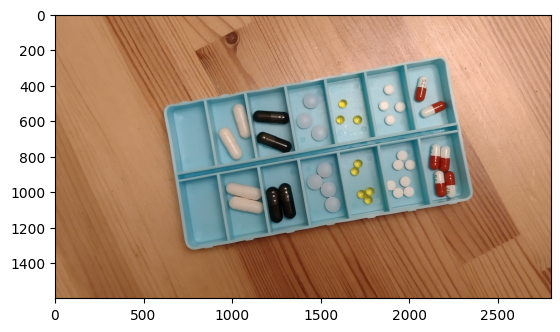

In [3]:
calib_img = cv2.imread("calib.png")
plt.imshow(cv2.cvtColor(calib_img, cv2.COLOR_BGR2RGB))

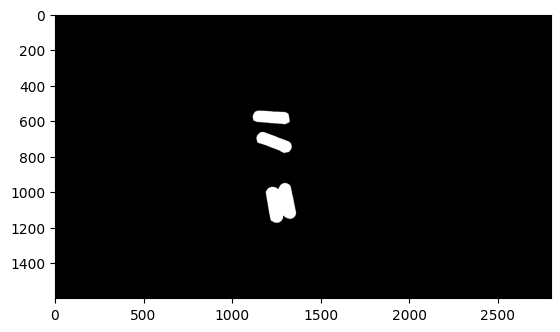

In [4]:
thresholded = ProbioDetector.threshold(calib_img)
plt.imshow(thresholded, cmap="gray")

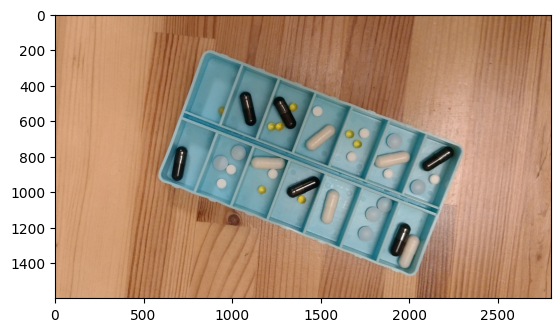

In [5]:
test_img = cv2.imread("test.png")
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

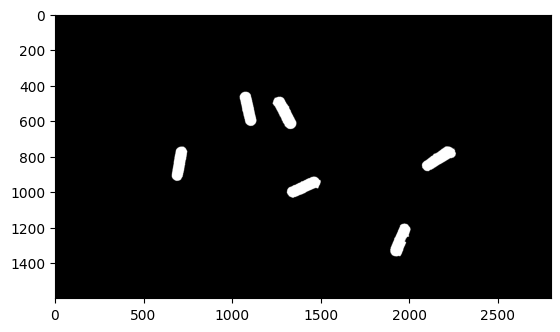

In [6]:
thresholded = ProbioDetector.threshold(test_img)
plt.imshow(thresholded, cmap="gray")